# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  # for pattern matching and text manipulation.
import string 
import nltk 
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 

# Load Data

In [6]:
train_data = pd.read_csv("train_data.txt", sep=':::', names=["title", "genre", "description"], engine='python')
test_data = pd.read_csv("test_data.txt", sep=':::', names=["title", "description"], engine='python')

# Data Visualisation

In [7]:
train_data.head()

,title,genre,description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [8]:
test_data.head()

,title,description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


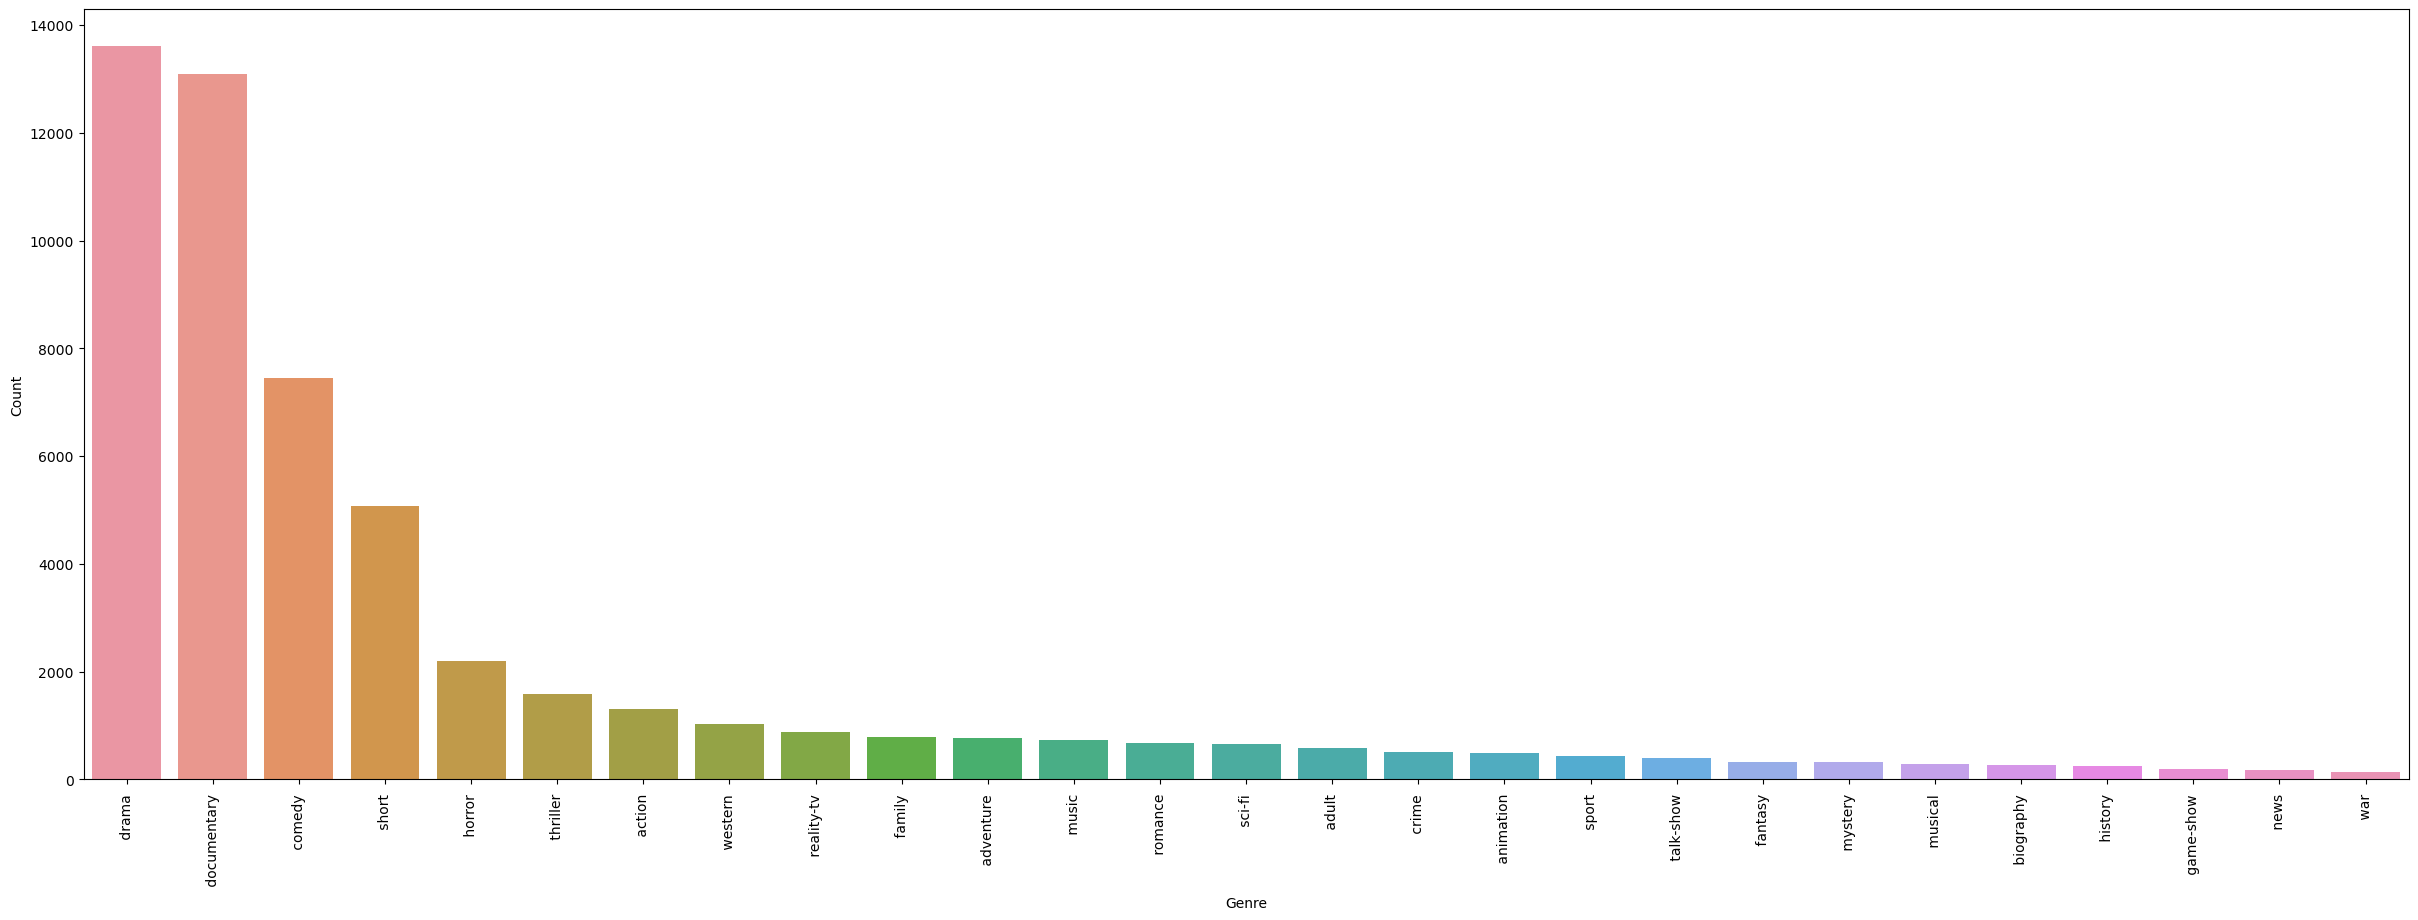

In [9]:
plt.figure(figsize=(30,10))
counts = train_data.genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);

In [10]:
train_data.describe()

,title,genre,description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [11]:
train_data.genre.value_counts()

genre
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

# Data Cleaning and Preprocessing


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [13]:
train_data.isnull().sum()

title          0
genre          0
description    0
dtype: int64

In [14]:
print("shape before drop nulls",train_data.shape)
# Droping the redundant data
train_data = train_data.drop_duplicates()
print("shape after drop nulls",train_data.shape)

shape before drop nulls (54214, 3)
shape after drop nulls (54214, 3)


# Text Cleaning

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download()

In [ ]:
stop_words = set(stopwords.words('english')) # stop words
def clean_data(text):
    text = text.lower()
    text = re.sub(r'@\S+','',text)                       # [1] remove mentions
    text = re.sub(r'http\S+', '', text)                  # [2] remove urls
    text = re.sub(r'[\w\.-]+@[\w\.-]+',"",text)          # [3] remove emails
    text = re.sub(r"[^a-zA-Z+']", ' ', text)             # [4] keep only english chars / remove numbers
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # [5] remove single chars
    text = re.sub(r'pic.\S+', '',text)                   # [6]
    text = re.sub(r'#', "", text)                        # [7] remove hashtags
    text = re.sub(r"_", "  ", text)                      # [8] remove hashtags
    text = re.sub('\n'," . ",text)                       # [9] remove new lines
    text = re.sub('\[[^]]*\]','',text)                   # [10] remove square prackets
    text = "".join([char for char in text if char not in string.punctuation]) # [11] remove punctuations
    text= re.sub("\s[\s]+", " ",text).strip()            # [12] remove repeated/leading/trailing spaces
    tokens = word_tokenize(text)                         # [13] Tokenize
    text = " ".join([word for word in tokens if word not in stop_words and len(word) > 2]) # [14] remove stop words
    
    return text

# Cell Statistics

In [ ]:
train_data['description_cleaned'] = train_data['description'].apply(clean_data)
test_data['description_cleaned'] = test_data['description'].apply(clean_data)

# Stemming

In [ ]:
st = PorterStemmer()
train_data['description_cleaned'] = train_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

test_data['description_cleaned'] = test_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

In [ ]:
train_data['length']=train_data['description'].apply(len)
train_data['length_cleaned']=train_data['description_cleaned'].apply(len)
train_data.head()

In [ ]:
print("Average Length of Text Before Cleaning: ", train_data['length'].mean())
print("Average Length of Text After Cleaning: ", train_data['length_cleaned'].mean())

In [ ]:
plt.figure(figsize=(8, 7))

sns.histplot(data=train_data, x='length', bins=20, kde=True, color='blue')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

# Get Top Bigrams

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_n_bigram(train_data['description_cleaned'], 10)
common_words_df = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='freq', y='word', data=common_words_df,facecolor='yellow',linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",10))

plt.title("Top 10 bigrams",font='Serif')
plt.xlabel("Frequency", fontsize=10)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=10)
plt.ylabel("");

# Label Encoding of Target Variable

In [ ]:
le = LabelEncoder()
train_data['genre'] = le.fit_transform(train_data['genre'].values)

# keep only relevent columns
train_df = train_data.loc[:,['description_cleaned', 'genre']]
test_df = test_data.loc[:,['description_cleaned', 'title']]
train_df.head(10)

# Train Test Split

In [ ]:
train_set , val_set , train_label , val_label = train_test_split(train_df['description_cleaned'] , train_data['genre'] , test_size=0.2 , shuffle=True , random_state = 42)

print(f'Split data into train and eval sets')
print(f'Trani Set\t: {len(train_set)}\nValidation Set\t: {len(val_set)}')

# Feature Extraction

In [ ]:
# using TF-IDF
vectorize = TfidfVectorizer(stop_words='english', max_features=100000)
train_set_tfidf = vectorize.fit_transform(train_set)
val_set_tfidf = vectorize.transform(val_set)

# 1)Logistic Regression Model

In [ ]:
LR_model = LogisticRegression()
LR_model.fit(train_set_tfidf, train_label)
predict_LR = LR_model.predict(val_set_tfidf)
print(classification_report(val_label, predict_LR))
LR_accuracy = accuracy_score(predict_LR,val_label)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

# 2) Multinomial Naive Bayes Model

In [ ]:
# Train a Naive Bayes classifier
NB_model = MultinomialNB()
NB_model.fit(train_set_tfidf, train_label)
y_pred_naive = NB_model.predict(val_set_tfidf)
print(classification_report(val_label, y_pred_naive))
naive_accuracy = accuracy_score(y_pred_naive,val_label)
print('Naive Bayes model accuracy is: {:.2f}%'.format(naive_accuracy*100))

# 3) Decision Tree Model(ID3)

In [ ]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(train_set_tfidf, train_label)
predict_ID3 = DT.predict(val_set_tfidf)
print(classification_report(val_label, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,val_label)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

# 4) Support Vector Machine Model

In [ ]:
# Train a SVC classifier
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(train_set_tfidf, train_label)
predict = svm_model.predict(val_set_tfidf)

print(classification_report(val_label, predict))
svm_accuracy = accuracy_score(predict,val_label)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

In [ ]:
columns=['LogisticRegression', 'MultinomialNB', 'Decision_Tree','SVC']
accuracy= [LR_accuracy, naive_accuracy, ID3_accuracy, svm_accuracy]

FinalResult=pd.DataFrame({'Algorithm':columns, 'Accuracy':accuracy})

FinalResult

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
plt.plot(FinalResult.Algorithm,accuracy,label="Accuracy")
plt.legend()
plt.show()